# Creating a seascape dataset class

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import copernicusmarine as cmems
import math

## Utility functions

In [2]:
def generate_points(n_points: int, lon_range: tuple, lat_range: tuple) -> pd.DataFrame:
    """
    Generates a `n_points`-long DataFrame with randomly selected geographical points in the specified
    longitude and latitude ranges.
    """
    min_lon, max_lon = lon_range
    min_lat, max_lat = lat_range
    lats = np.random.uniform(min_lat, max_lat, size=(n_points,))
    lons = np.random.uniform(min_lon, max_lon, size=(n_points,))
    points = pd.DataFrame({
        'lat': lats,
        'lon': lons
    })
    return points

def plot_points(points: pd.DataFrame, ax:GeoAxes = None) -> None:
    if ax is None:
        ax = plt.gca()
    
    ax.coastlines()
    ax.scatter(points['lon'], points['lat'], transform=ccrs.PlateCarree(), marker='x', c='black')

def get_request_extent(points: pd.DataFrame, seascape_size: float, gridsize: float):
    # Sizes in degrees
    return {
    'maximum_latitude': points['lat'].max() + gridsize + seascape_size/2,
    'minimum_latitude': points['lat'].min() - gridsize - seascape_size/2,
    'maximum_longitude': points['lon'].max() + gridsize + seascape_size/2,
    'minimum_longitude': points['lon'].min() - gridsize - seascape_size/2,
    }

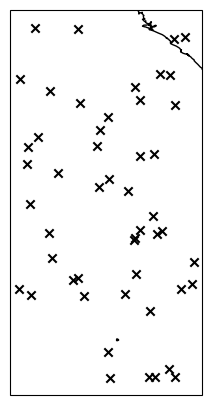

In [3]:
points = generate_points(50, (-20,-10), (-10,8))

fig, ax = plt.subplots(1,1,figsize=(10,5), subplot_kw={'projection':ccrs.Robinson()})
plot_points(points)

## Xarray ~~class~~ DataArray creation function

See this for why a class is a bad idea: https://docs.xarray.dev/en/stable/internals/extending-xarray.html

In [4]:
# Prerequisites
seascape_size = 2.5
gridsize=1/12

extent = get_request_extent(points, seascape_size, gridsize)
data_request = {
    'dataset_id': 'cmems_mod_glo_phy_my_0.083deg_P1D-m',
    'variables': ['zos', 'thetao', 'so', 'mlotst'],
    'start_datetime': "2000-01-01",
    'end_datetime' : "2000-12-31",
    'maximum_latitude': extent['maximum_latitude'],
    'minimum_latitude': extent['minimum_latitude'],
    'maximum_longitude': extent['maximum_longitude'],
    'minimum_longitude': extent['minimum_longitude'],
    }

glorys_ds = cmems.open_dataset(**data_request)

INFO - 2025-01-29T14:56:43Z - Selected dataset version: "202311"
INFO - 2025-01-29T14:56:43Z - Selected dataset part: "default"


In [5]:
var_da = glorys_ds.thetao.isel(time=0,depth=0).rename({# 2D to start with
    'latitude': 'lat',
    'longitude': 'lon'
}) 

In [6]:
def get_gridcenter_points(
    points: pd.DataFrame, 
    var_da:xr.DataArray
    ) -> pd.DataFrame:
    """
    Returns a DataFrame with a list of (lat,lon) points, which correspond to the coordinates of the
    pixels of `var_da` in which each point in `points` is.
    """
    
    # Function to find the nearest grid point
    def find_nearest(value, grid):
        return grid[np.abs(grid - value).argmin()]

    c_points = points.copy()
    c_points['lat'] = points['lat'].apply(lambda x: find_nearest(x, var_da['lat'].values))
    c_points['lon'] = points['lon'].apply(lambda x: find_nearest(x, var_da['lon'].values))
    return c_points.drop_duplicates()


In [7]:
def create_xscp_da(
    points: pd.DataFrame,
    seascape_size: float,
    var_da:xr.DataArray,
    ) -> xr.DataArray:

    # Calculate gridsize
    lat_gridsize = np.diff(var_da.lat.values).mean()
    lon_gridsize = np.diff(var_da.lon.values).mean()
    # TODO: Allow different sizes in lat and lon
    gridsize = (lat_gridsize + lon_gridsize) / 2

    c_points = get_gridcenter_points(points, var_da)
    
    n_seascapes = c_points.shape[0]
    n_ss_gridpoints = math.ceil(seascape_size // gridsize)
    if not (n_ss_gridpoints % 2): n_ss_gridpoints += 1 # Must be odd to have a center pixel.

    # Calculate values in relative seascape grid
    half_range = (n_ss_gridpoints // 2) * gridsize
    ss_rlat_vals = np.linspace(-half_range, half_range, n_ss_gridpoints)
    ss_rlon_vals = np.linspace(-half_range, half_range, n_ss_gridpoints)

    # Calculate values of seascape and
    # stack them in a seascape_idx dimension

    # xscp_data = np.empty(shape=(n_seascapes, n_ss_gridpoints, n_ss_gridpoints))
    ss_list = []

    for ss_idx, c_point in c_points.iterrows():
        c_point_lon = c_point['lon']
        c_point_lat = c_point['lat']
        seascape = var_da.sel(
            lat=slice(
                c_point_lat-(seascape_size+gridsize)/2,
                c_point_lat+(seascape_size+gridsize)/2
                ),
            lon=slice(
                c_point_lon-(seascape_size+gridsize)/2,
                c_point_lon+(seascape_size+gridsize)/2
                )
            )
        if seascape.size == 0:
            # TODO: Add error handling for empty seascapes
            raise NotImplementedError(f"Empty seascape for index {ss_idx}")
        else:
            # Change global coords to relative ss coords
            seascape = seascape.assign_coords(
                lat=ss_rlat_vals,
                lon=ss_rlon_vals
            )
            ss_list.append(seascape)


    xscp_data = xr.concat(
        ss_list, 
        pd.RangeIndex(
            n_seascapes,
            name='seascape_idx'
            )
        )

    # Construct DataArray
    xscp_da = xr.DataArray(
        data=xscp_data,
        coords={
            # Center pixel coordinates for each ss
            'c_lon': ('seascape_idx', c_points['lon']),
            'c_lat': ('seascape_idx', c_points['lat']),
            # Relative lat/lon with center pixel at (0,0)
            'ss_rlon': ('ss_rlon', ss_rlon_vals),
            'ss_rlat': ('ss_rlat', ss_rlat_vals),
            # Real-world coordinates for each pixel in each ss
            'ss_lon': (('seascape_idx','ss_rlon'),\
                       c_points["lat"].values[:, np.newaxis] + ss_rlat_vals),
            'ss_lat': (('seascape_idx','ss_rlat'),\
                       c_points["lon"].values[:, np.newaxis] + ss_rlon_vals),
        },
        dims=['seascape_idx', 'ss_rlon', 'ss_rlat'],
        name=f"{var_da.name}"
        # TODO: Add attrs
    )

    return xscp_da

xscp_da = create_xscp_da(points, seascape_size, var_da)

In [8]:
xscp_da

<xarray.DataArray 'thetao' (seascape_idx: 50, ss_rlon: 31, ss_rlat: 31)> Size: 384kB
dask.array<concatenate, shape=(50, 31, 31), dtype=float64, chunksize=(1, 3, 2), chunktype=numpy.ndarray>
Coordinates:
    c_lon    (seascape_idx) float32 200B -10.83 -16.83 -18.17 ... -11.5 -10.58
    c_lat    (seascape_idx) float32 200B -5.417 -5.0 -2.667 ... 4.583 -9.417 7.0
  * ss_rlon  (ss_rlon) float32 124B -1.25 -1.167 -1.083 ... 1.083 1.167 1.25
  * ss_rlat  (ss_rlat) float32 124B -1.25 -1.167 -1.083 ... 1.083 1.167 1.25
    ss_lon   (seascape_idx, ss_rlon) float32 6kB -6.667 -6.583 ... 8.167 8.25
    ss_lat   (seascape_idx, ss_rlat) float32 6kB -12.08 -12.0 ... -9.417 -9.333
Dimensions without coordinates: seascape_idx
Attributes:
    unit_long:      Degrees Celsius
    valid_min:      -32766
    valid_max:      21306
    standard_name:  sea_water_potential_temperature
    long_name:      Temperature
    units:          degrees_C